# This notebook allows the recreation of figures in the paper based on the resources provided in the linked github (https://github.com/fowler-lab/tb-rnap-compensation.git)

Load all necessary packages

In [89]:
import pandas
import numpy
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu
from scipy.stats import bootstrap
import pylab
import scipy

Load all relevant data sets

In [15]:
MUTATIONS = pandas.read_pickle('tb_rnap_compensation/tables/MUTATIONS.pkl.gz')
MUTATIONS.reset_index(inplace = True)
MUTATIONS = MUTATIONS.astype({'GENE':'str'})
MUTATIONS['GENE_MUTATION'] = MUTATIONS['GENE'] + '_' + MUTATIONS['MUTATION']

len(MUTATIONS.UNIQUEID.unique())

66824

In [16]:
GENOMES = pandas.read_pickle('tb_rnap_compensation/tables/GENOMES.pkl.gz')

GENOMES

,SITEID,SUBJID,LABID,ISOLATENO,SEQREPS,BELONGS_GPI,PER_SAMPLE_VCF_PRESENT,REGENOTYPED_VCF_PRESENT,CLOCKWORK_VERSION,TBI_INDEX,...,IMAGE_MD5SUM,FTP_PATH,FTP_FILENAME_VCF,TREE_PATH,TREE_FILENAME_VCF,FASTQ_MD5SUMS,SEQTREAT_SAMPLE,MYKROBE_LINEAGE_NAME_1,MYKROBE_LINEAGE_NAME_2,ENA
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
site.02.subj.0958.lab.22A197.iso.1,02,0958,22A197,1,197,True,True,True,0.8.3,True,...,{'02-0958-22A197-1-14': 'a587bac9ad2a0ebd36274...,/well/bag/jeffk/release_staging/,00/01/41/00/14100/site.02.iso.1.subject.0958.l...,dat/CRyPTIC2/V2/02/0958/22A197/1/regenotyped/,site.02.subj.0958.lab.22A197.iso.1.v0.8.3.rege...,,False,Lineage 2,lineage2.2.1,ERS5301054
site.02.subj.0823.lab.2013241494.iso.1,02,0823,2013241494,1,241494,True,True,True,0.8.3,True,...,{'02-0823-2013241494-1-14': '698507bed7ff19268...,/well/bag/jeffk/release_staging/,00/01/41/43/14143/site.02.iso.1.subject.0823.l...,dat/CRyPTIC2/V2/02/0823/2013241494/1/regenotyped/,site.02.subj.0823.lab.2013241494.iso.1.v0.8.3....,,False,Lineage 2,lineage2.2.3,ERS5301097
site.02.subj.0359.lab.222018-14.iso.1,02,0359,222018-14,1,14222018,True,True,True,0.8.3,True,...,{'02-0359-222018-14-1-14': '39c28529c7564ce379...,/well/bag/jeffk/release_staging/,00/01/08/73/10873/site.02.iso.1.subject.0359.l...,dat/CRyPTIC2/V2/02/0359/222018-14/1/regenotyped/,site.02.subj.0359.lab.222018-14.iso.1.v0.8.3.r...,,False,Lineage 2,lineage2.2.3,ERS5298526
site.02.subj.0224.lab.2013221088.iso.1,02,0224,2013221088,1,13221088_2013221088,True,True,True,0.8.3,True,...,,/well/bag/jeffk/release_staging/,00/01/13/37/11337/site.02.iso.1.subject.0224.l...,dat/CRyPTIC2/V2/02/0224/2013221088/1/regenotyped/,site.02.subj.0224.lab.2013221088.iso.1.v0.8.3....,,False,Lineage 2,lineage2.2.5,ERS5300527
site.02.subj.0918.lab.22A153.iso.1,02,0918,22A153,1,153,True,True,True,0.8.3,True,...,{'02-0918-22A153-1-14': 'b48e27b23f8377c209854...,/well/bag/jeffk/release_staging/,00/01/40/62/14062/site.02.iso.1.subject.0918.l...,dat/CRyPTIC2/V2/02/0918/22A153/1/regenotyped/,site.02.subj.0918.lab.22A153.iso.1.v0.8.3.rege...,,False,Lineage 2,lineage2.2.3,ERS5301016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.10.subj.YA00023171.lab.YA00023171.iso.1,10,YA00023171,YA00023171,1,1,True,True,True,0.8.3,True,...,{'10-YA00023171-YA00023171-1-7': 'da79aa0564b0...,/well/bag/jeffk/release_staging/,00/00/31/24/3124/site.10.iso.1.subject.YA00023...,dat/CRyPTIC2/V2/10/YA00023171/YA00023171/1/reg...,site.10.subj.YA00023171.lab.YA00023171.iso.1.v...,,False,Lineage 4,lineage4.3.2.1,ERS5298216
site.10.subj.SADH00634109_S16.lab.DH00634109_S16.iso.1,10,SADH00634109_S16,DH00634109_S16,1,1,False,True,False,0.8.3,True,...,,/well/bag/jeffk/release_staging/,00/00/81/50/8150/site.10.iso.1.subject.SADH006...,dat/CRyPTIC2/V2/10/SADH00634109_S16/DH00634109...,site.10.subj.SADH00634109_S16.lab.DH00634109_S...,,False,Lineage 4,lineage4.3.2,ERS2400531
site.10.subj.H37RV_SA2437.lab.H37RV_SA2437.iso.1,10,H37RV_SA2437,H37RV_SA2437,1,1,False,True,False,0.8.3,True,...,,/well/bag/jeffk/release_staging/,00/01/45/29/14529/site.10.iso.1.subject.H37Rv_...,dat/CRyPTIC2/V2/10/H37RV_SA2437/H37RV_SA2437/1...,site.10.subj.H37RV_SA2437.lab.H37RV_SA2437.iso...,,False,Lineage 4,lineage4.10,NO_ENA


In [17]:
EFFECTS = pandas.read_pickle('tb_rnap_compensation/tables/EFFECTS.pkl.gz')
EFFECTS.reset_index(inplace = True)
EFFECTS['GENE_MUTATION'] = EFFECTS['GENE'] + '_' + EFFECTS['MUTATION']
EFFECTS = EFFECTS[(EFFECTS.DRUG=='RIF') & (EFFECTS.PREDICTION=='R') 
                  & (~EFFECTS.MUTATION.str[-1].isin(['O','X']))]

EFFECTS.MUTATION.value_counts()

S450L    13609
D435V     1430
H445Y      756
H445D      693
D435Y      569
         ...  
L449Q        1
S428N        1
G981D        1
L452T        1
L452V        1
Name: MUTATION, Length: 113, dtype: int64

In [18]:
lineage_mut = pandas.read_csv('lineage_MUTATIONS.csv')
lineage_mut['GENE_MUTATION'] = lineage_mut['GENE'] + '_' + lineage_mut['MUTATION']

lineage_mut

,Unnamed: 0,SNPIT_ID,SPECIES,LINEAGE,SUBLINEAGE,GENE,MUTATION,GENE_MUTATION
0,0,Dassie,Dassie bacillus (ex Procavia capensis),NaN,NaN,PE_PGRS11,T469N,PE_PGRS11_T469N
1,1,Dassie,Dassie bacillus (ex Procavia capensis),NaN,NaN,PE_PGRS11,R512L,PE_PGRS11_R512L
2,2,Dassie,Dassie bacillus (ex Procavia capensis),NaN,NaN,PE_PGRS11,P518L,PE_PGRS11_P518L
3,3,Dassie,Dassie bacillus (ex Procavia capensis),NaN,NaN,PE_PGRS2,A52S,PE_PGRS2_A52S
4,4,Dassie,Dassie bacillus (ex Procavia capensis),NaN,NaN,PE_PGRS30,G309R,PE_PGRS30_G309R
...,...,...,...,...,...,...,...,...
12635,12635,xtype,M. tuberculosis,Lineage 4,X-type,ppgK,N140S,ppgK_N140S
12636,12636,xtype,M. tuberculosis,Lineage 4,X-type,prpC,D225D,prpC_D225D
12637,12637,xtype,M. tuberculosis,Lineage 4,X-type,pyrB,G134G,pyrB_G134G
12638,12638,xtype,M. tuberculosis,Lineage 4,X-type,recC,F497L,recC_F497L


In [19]:
PLATES = pandas.read_pickle('tb_rnap_compensation/tables/UKMYC_PLATES.pkl.gz')
PLATES.reset_index(inplace = True)

PLATES

,UNIQUEID,SITEID,SUBJID,LABID,ISOLATENO,READINGDAY,BELONGS_GPI,PLATEDESIGN,TREE_PATH,IMAGEFILENAME,IMAGE_MD5SUM,DUPLICATED_IMAGE,IM_IMAGE_DOWNLOADED,IM_IMAGE_FILTERED,IM_WELLS_IDENTIFIED,IM_POS1GROWTH,IM_POS2GROWTH,IM_POS_AVERAGE,IM_DRUGS_INCONSISTENT_GROWTH,TRUST_PHENOTYPES
0,site.11.subj.MDR044.lab.SWE-33.iso.1,11,MDR044,SWE-33,1,10,False,UKMYC5,dat/CRyPTIC2/V2/11/MDR044/SWE-33/1/10/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True
1,site.11.subj.MDR045.lab.SWE-34.iso.1,11,MDR045,SWE-34,1,10,True,UKMYC5,dat/CRyPTIC2/V2/11/MDR045/SWE-34/1/10/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True
2,site.11.subj.MDR046.lab.SWE-35.iso.1,11,MDR046,SWE-35,1,10,True,UKMYC5,dat/CRyPTIC2/V2/11/MDR046/SWE-35/1/10/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True
3,site.11.subj.MDR047.lab.SWE-36.iso.1,11,MDR047,SWE-36,1,10,True,UKMYC5,dat/CRyPTIC2/V2/11/MDR047/SWE-36/1/10/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True
4,site.11.subj.MDR048.lab.SWE-37.iso.1,11,MDR048,SWE-37,1,10,True,UKMYC5,dat/CRyPTIC2/V2/11/MDR048/SWE-37/1/10/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20632,site.17.subj.P3038.lab.086-15-3038-B.iso.1,17,P3038,086-15-3038-B,1,21,True,UKMYC6,dat/CRyPTIC2/V2/17/P3038/086-15-3038-B/1/21/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True
20633,site.17.subj.P3424.lab.086-15-3424-B.iso.1,17,P3424,086-15-3424-B,1,21,True,UKMYC6,dat/CRyPTIC2/V2/17/P3424/086-15-3424-B/1/21/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True
20634,site.17.subj.P3524.lab.086-15-3524-B.iso.1,17,P3524,086-15-3524-B,1,21,True,UKMYC6,dat/CRyPTIC2/V2/17/P3524/086-15-3524-B/1/21/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True
20635,site.17.subj.P3524.lab.086-15-3524-M2.iso.1,17,P3524,086-15-3524-M2,1,21,True,UKMYC6,dat/CRyPTIC2/V2/17/P3524/086-15-3524-M2/1/21/,NaN,NaN,False,False,False,False,0.0,0.0,NaN,NaN,True


**Figure 1: Close-up of the drug rifampicin (RIF) bound to the β subunit of the RNA polymerase (RNAP)**

Done outside this notebook

**Figure 2: Growth distributions for pan-susceptible vs rifampicin (RIF) resistant samples in M. tuberculosis**

**2(A)** Distribution of growth in percent of covered well area as measured in a previous project, plotted against the proportion of samples that display this amount of growth. This plot represents the overall data set.

2.9538806538738147e-12 17.57 22.1
ConfidenceInterval(low=14.896497745861174, high=18.058377358799913)
ConfidenceInterval(low=17.843913506558934, high=18.72746979835627)


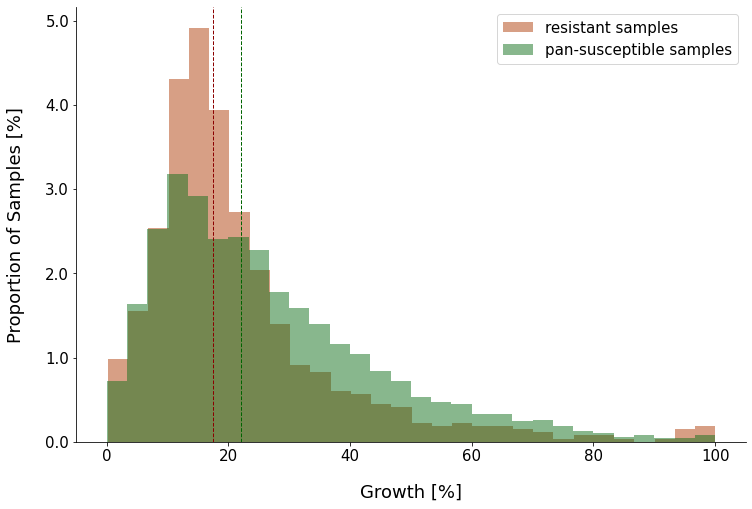

In [78]:
#set color palette
colors = sns.color_palette("dark")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#load UNIQUEIDs of susceptible samples
pan_sus_samples = GENOMES[(GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS']))].index.to_series()

#make query for samples with resistance and only synonymous other mutations
res_gene_mutations = EFFECTS.GENE_MUTATION
query = res_gene_mutations.unique()

MUTATIONS['SYNONYMOUS'] = MUTATIONS['MUTATION'].apply(lambda x: x[0]==x[-1])
syn_mutations = MUTATIONS[MUTATIONS.SYNONYMOUS].GENE_MUTATION.unique()
query = numpy.append(query, syn_mutations)

MUTATIONS['QUERY'] = MUTATIONS.GENE_MUTATION.isin(query)
tmp = MUTATIONS.groupby(MUTATIONS.UNIQUEID).mean()
only_query = tmp[tmp.QUERY == 1].index.to_series()

#load UNIQUEIDs of resistant samples
only_res = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(res_gene_mutations.unique())) 
                     & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID

#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(only_res.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#calculate p-value
stat, p = mannwhitneyu(resistant, susceptible)
print(p, resistant.median(), susceptible.median())

#save p-value and median
p_values_medians = []
p_values_medians.append(['any resistance', round(numpy.mean(resistant), 2), p, len(resistant)])

#calculate and print confidence intervals
for state in (resistant, susceptible):
    state = (state,)
    CI = bootstrap(state, numpy.std, confidence_level = 0.95)
    print(CI.confidence_interval)

#plot growth distributions
fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(12, 8)

plt.hist(resistant, bins = 30, alpha = 0.5, label="resistant samples", density = True, color = colors[1])
plt.axvline(resistant.median(), color = 'darkred', linestyle='dashed', linewidth = 1)

plt.hist(susceptible, bins = 30, alpha = 0.5, label="pan-susceptible samples", density = True, color = colors[2])
plt.axvline(susceptible.median(), color = 'darkgreen', linestyle='dashed', linewidth = 1)

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)

plt.xticks(fontsize = 15)

y = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05]
values = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
plt.yticks(y, values, fontsize = 15)

plt.legend(loc = 'upper right', fontsize = 15)

2.9538806538738147e-12 21.947509433962264 26.477469240961575
ConfidenceInterval(low=20.863855031264833, high=23.163535199504025)
ConfidenceInterval(low=25.98997030571036, high=26.96981037841592)
19.52395413338362


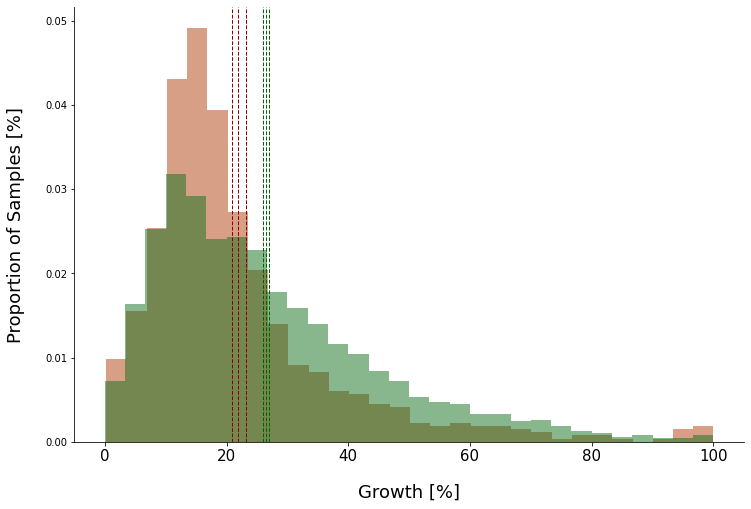

In [115]:
#set color palette
colors = sns.color_palette("dark")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#load UNIQUEIDs of susceptible samples
pan_sus_samples = GENOMES[(GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS']))].index.to_series()

#make query for samples with resistance and only synonymous other mutations
res_gene_mutations = EFFECTS.GENE_MUTATION
query = res_gene_mutations.unique()

MUTATIONS['SYNONYMOUS'] = MUTATIONS['MUTATION'].apply(lambda x: x[0]==x[-1])
syn_mutations = MUTATIONS[MUTATIONS.SYNONYMOUS].GENE_MUTATION.unique()
query = numpy.append(query, syn_mutations)

MUTATIONS['QUERY'] = MUTATIONS.GENE_MUTATION.isin(query)
tmp = MUTATIONS.groupby(MUTATIONS.UNIQUEID).mean()
only_query = tmp[tmp.QUERY == 1].index.to_series()

#load UNIQUEIDs of resistant samples
only_res = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(res_gene_mutations.unique())) 
                     & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID

#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(only_res.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#calculate p-value
stat, p = mannwhitneyu(resistant, susceptible)
print(p, numpy.mean(resistant), numpy.mean(susceptible))

#save p-value and median
p_values_medians = []
p_values_medians.append(['any resistance', round(numpy.mean(resistant), 2), p, len(resistant)])

#calculate and print confidence intervals
for state in (resistant, susceptible):
    state = (state,)
    CI = bootstrap(state, numpy.mean, confidence_level = 0.95)
    print(CI.confidence_interval)
    
#plot growth distributions
fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(12, 8)

plt.hist(resistant, bins = 30, alpha = 0.5, label="resistant samples", density = True, color = colors[1])
plt.axvline(numpy.mean(resistant), color = 'darkred', linestyle='dashed', linewidth = 1)
plt.axvline(bootstrap((resistant,), numpy.mean, confidence_level = 0.95).confidence_interval[0], color = 'darkred', linestyle='dashed', linewidth = 1)
plt.axvline(bootstrap((resistant,), numpy.mean, confidence_level = 0.95).confidence_interval[1], color = 'darkred', linestyle='dashed', linewidth = 1)

plt.hist(susceptible, bins = 30, alpha = 0.5, label="pan-susceptible samples", density = True, color = colors[2])
plt.axvline(numpy.mean(susceptible), color = 'darkgreen', linestyle='dashed', linewidth = 1)
plt.axvline(bootstrap((susceptible,), numpy.mean, confidence_level = 0.95).confidence_interval[0], color = 'darkgreen', linestyle='dashed', linewidth = 1)
plt.axvline(bootstrap((susceptible,), numpy.mean, confidence_level = 0.95).confidence_interval[1], color = 'darkgreen', linestyle='dashed', linewidth = 1)

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)

plt.xticks(fontsize = 15)

#y = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05]
#values = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
#plt.yticks(y, values, fontsize = 15)

#plt.legend(loc = 'upper right', fontsize = 15)

#scipy.stats.probplot(resistant, dist = "norm", plot = pylab)
#pylab.show()

#scipy.stats.probplot(numpy.log(resistant), dist = "norm", plot = pylab)
#pylab.show()

#scipy.stats.probplot(numpy.sqrt(resistant), dist = "norm", plot = pylab)
#pylab.show()

print((numpy.mean(numpy.sqrt(resistant)))**2)

**2(B-D)** Plot layout as in A, but the red bar plot represents a subset of RIF resistant samples that exhibit only the resistance mutation indicated in the legend and no other potentially interfering mutations.

rpoB_S450L 0.004370955721574559
ConfidenceInterval(low=18.818892946005718, high=24.496429083909025)
ConfidenceInterval(low=17.841528781119862, high=18.743609835254375)
rpoB_H445Y 0.01260896272020915
ConfidenceInterval(low=15.197470652111347, high=31.62442336320562)
ConfidenceInterval(low=17.85585215696965, high=18.71989861276423)
rpoB_D435V 3.9207542608554665e-14
ConfidenceInterval(low=8.420903054285528, high=13.340103516389501)
ConfidenceInterval(low=17.819255851173814, high=18.726486089068587)


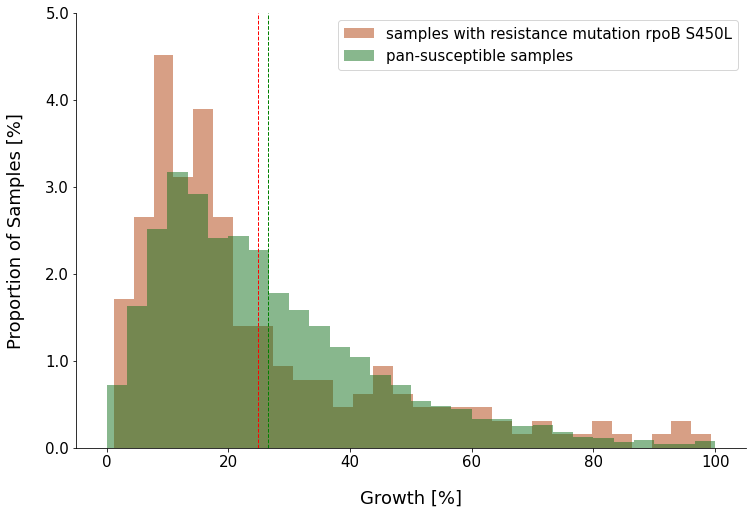

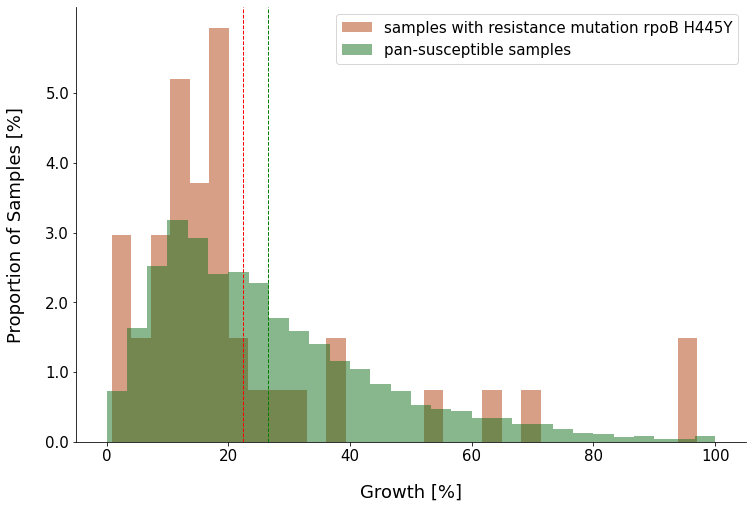

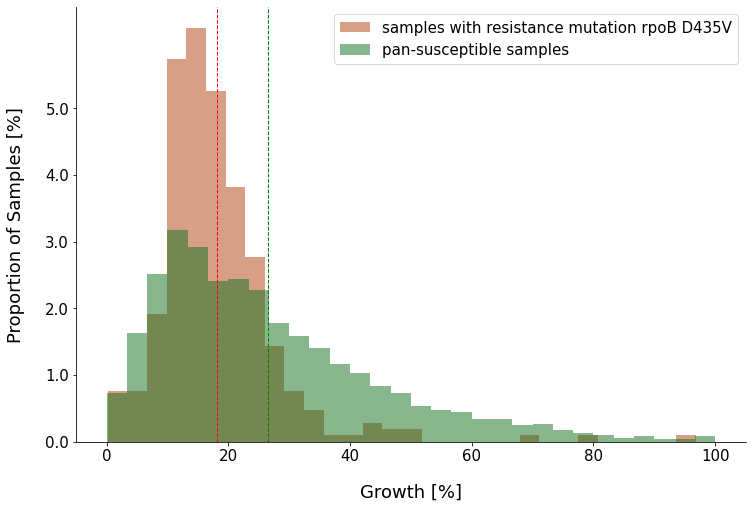

In [67]:
#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#fetch resistance mutations
res_gene_mutations = EFFECTS.GENE_MUTATION.unique()

#iterate through resistance mutations
for res in res_gene_mutations:
    
    #query for samples with resistance and only synonymous other mutations
    spec_res = MUTATIONS[(MUTATIONS.GENE_MUTATION == res) & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID
    
    #load growth data for resistant UNIQUEIDs
    resistant = PLATES[(PLATES.UNIQUEID.isin(spec_res.values.tolist()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #set reasonable prevalence cut-off for resistance mutation
    if len(resistant) < 40:
        continue
    
    #calculate p-value
    stat, p = mannwhitneyu(resistant, susceptible)
    print(res, p)
    
    #calculate and print confidence intervals
    for state in (resistant, susceptible):
        state = (state,)
        CI = bootstrap(state, numpy.std, confidence_level = 0.95, n_resamples = 1000)
        print(CI.confidence_interval)
    
    #plot growth distributions below p-value cut-off
    if p < (0.05):
        
        fig, ax = plt.subplots()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        fig.set_size_inches(12, 8)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.hist(resistant, bins = 30, alpha = 0.5, 
                 label = "samples with resistance mutation " + res[0:4] + ' ' + res[5:], 
                 density = True, color = colors[1])
        plt.axvline(numpy.mean(resistant), color = 'r', linestyle = 'dashed', linewidth=1)
        
        plt.hist(susceptible, bins = 30, alpha = 0.5, label = "pan-susceptible samples", 
                 density = True, color = colors[2])
        plt.axvline(numpy.mean(susceptible), color = 'g', linestyle = 'dashed', linewidth = 1)
        
        plt.xlabel("Growth [%]", size = 18, labelpad = 20)
        plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
        
        plt.xticks(fontsize = 15)
        plt.yticks(y, values, fontsize = 15)
        
        plt.legend(loc = 'upper right', fontsize = 15)
        
        #save p-value and median
        p_values_medians.append([res, round(numpy.mean(resistant), 2), p, len(resistant)])
        

**Table 1: Median growth of samples with different resistance mutations.**

Mann-Whitney p-value is calculated in reference to pan- susceptible sample growth and n indicates the sample size.

In [24]:
table = pandas.DataFrame(p_values_medians, columns = ['mutation','mean growth [%]', 'p-value', 'n'], index = None)
print(table.to_latex(index = False))

\begin{tabular}{lrrr}
\toprule
      mutation &  mean growth [\%] &      p-value &   n \\
\midrule
any resistance &            21.95 & 2.953881e-12 & 795 \\
    rpoB\_S450L &            24.89 & 4.370956e-03 & 196 \\
    rpoB\_H445Y &            22.39 & 1.260896e-02 &  42 \\
    rpoB\_D435V &            18.18 & 3.920754e-14 & 325 \\
    rpoB\_S450L &            24.89 & 4.370956e-03 & 196 \\
    rpoB\_H445Y &            22.39 & 1.260896e-02 &  42 \\
    rpoB\_D435V &            18.18 & 3.920754e-14 & 325 \\
\bottomrule
\end{tabular}



**Figure 3: Sensitivity and number of significant hits (putative CMs) depending on prevalence cut-off decision and p-value**

To obtain the below data, 
Run script 1: 'calculate-fisher-tests.py' with different settings for: 
- n_other and n_resistance can be varied and determine cutoffs for prevalence of mutations that are considered for analysis

Run script 2: 'results-evaluation.py' with different settings for:
- p_value, correct_p_value and method can be varied to change the p-value that is needed to deem an association significant and to compare to either a conservative or inclusive list of reference CMs ('Ref_CMs.xlsx')

**3(A)** I tested script 1 for cut-offs = [25, 30, 40, 45, 50, 60, 70, 80, 90] combined with script 2 p-value = 0.01 including Bonferroni correction for multiple testing and plotted ratio of found conservative references (TPR/ Sensitivity), as well as number of detected hits (stars indicate chosen cutoffs):

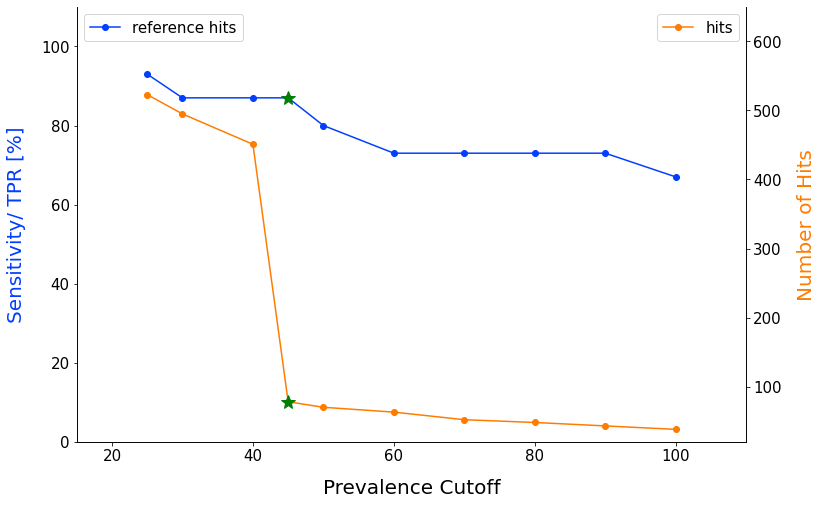

In [26]:
#set color palette
colors = sns.color_palette("bright")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#insert captured reference CMs and overall hits for given cut-off as obtained by running script 1: 
#'calculate-fisher-tests.py'
cutoff = [25,30,40,45,50,60,70,80,90,100]

n_refs = [0.93, 0.87, 0.87, 0.87, 0.8, 0.73, 0.73, 0.73, 0.73, 0.67]
n_refs = [element * 100 for element in n_refs]

n_hits = [523, 495, 451, 78, 70, 63, 52, 48, 43, 38]

#plot graphs
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 8)

ax1.spines["top"].set_visible(False)
ax1.tick_params(labelsize = 15)

ax1.set_xlim(15, 110)
ax1.set_ylim(0, 110)

ax1.set_xlabel('Prevalence Cutoff', size = 20, labelpad = 15)
ax1.set_ylabel('Sensitivity/ TPR [%]', size = 20, labelpad = 15)
ax1.yaxis.label.set_color(colors[0])

ax1.plot(cutoff, n_refs, color = colors[0], marker = 'o', label = 'reference hits')
plt.plot(cutoff[3], n_refs[3], 'g*', markersize = 15)
ax1.tick_params(axis = 'y')
ax1.legend(loc = 2, fontsize = 15)

ax2 = ax1.twinx()
ax2.spines["top"].set_visible(False)
ax2.tick_params(labelsize = 15)

ax2.set_ylim(20, 650)

ax2.set_ylabel('Number of Hits', size = 20, labelpad = 15)
ax2.yaxis.label.set_color(colors[1])

ax2.plot(cutoff, n_hits, color = colors[1], marker = 'o', label = 'hits')
plt.plot(cutoff[3], n_hits[3], 'g*', markersize = 15)
ax2.tick_params(axis = 'y')
ax2.legend(loc = 0, fontsize = 15)

**3(B)** The prevalence cutoff for script 1 was set to 45 for both resistance and other mutations and for this setting I evaluated the number of new hits depending on p-value = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9] for script 2 'results-evaluation.py'.
The star indicates the number of hits for a p-value of 0.01 with Bonferroni, which was chosen for downstream analysis:

(array([ 70.,  80.,  90., 100., 110., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

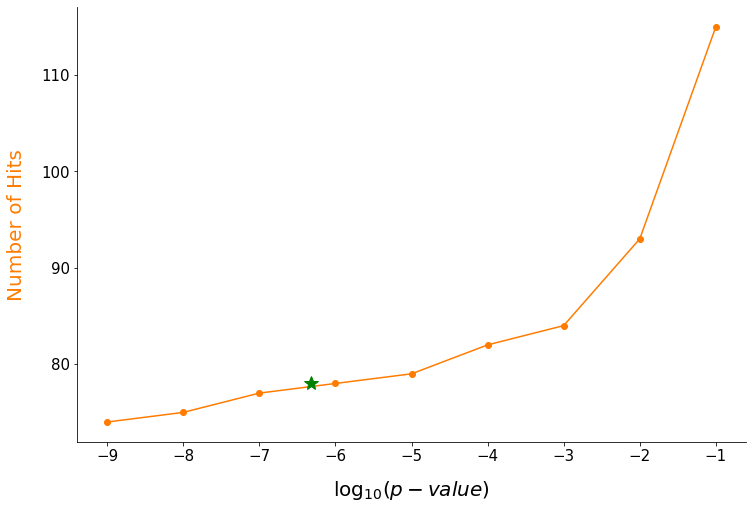

In [27]:
#insert overall hits for given p-value as obtained by running script 2: 'results-evaluation.py'
p_value = [0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001, 0.00000001, 0.000000001]
p_value = numpy.log10(p_value)

n_hits = [115, 93, 84, 82, 79, 78, 77, 75, 74]

#plot graphs
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.plot(p_value,n_hits, marker = 'o', color = colors[1])
plt.plot(numpy.log10(4.76190476190476E-07), 78, 'g*', markersize = 15)

plt.xlabel(r'$\log_{10} (p-value)$', size = 20, labelpad = 15)
plt.ylabel('Number of Hits', size = 20, labelpad = 15, color = colors[1])

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

**Table S1: Preliminary hit list of Fisher’s exact test for association of resistance with co-occuring mutations.**

In [30]:
hits = pandas.read_excel('hits.xlsx')
hits = hits.rename(columns = {'resistant_mutation': 'resistance mutation', 'other_mutation': 'putative CM'})

print(hits.to_latex(index = False))

\begin{tabular}{ll}
\toprule
resistance mutation &    putative CM \\
\midrule
         rpoB\_S450L &     rpoC\_N826T \\
         rpoB\_S450L &     rpoC\_D485Y \\
         rpoB\_S450L &     rpoB\_A692T \\
         rpoB\_S450L &     rpoB\_I480V \\
         rpoB\_S450L &     rpoC\_H525Q \\
         rpoB\_S450L &     rpoA\_V183G \\
         rpoB\_S450L &    rpoC\_E1092D \\
         rpoB\_L430P &    rpoC\_E1092D \\
         rpoB\_V170F &    rpoC\_E1092D \\
         rpoB\_S450L &     rpoB\_A286V \\
         rpoB\_S450L &     rpoB\_V496A \\
         rpoB\_S450L &     rpoC\_T812I \\
         rpoB\_S450L &     rpoC\_G519D \\
         rpoB\_S450W &     rpoC\_G519D \\
         rpoB\_D435Y &     rpoB\_c-61t \\
         rpoB\_D435G &    rpoB\_I1106T \\
         rpoB\_L452P &    rpoB\_I1106T \\
         rpoB\_S450L &     rpoC\_W484G \\
         rpoB\_V170F &     rpoC\_W484G \\
         rpoB\_S450L &    rpoC\_P1040S \\
         rpoB\_S450L &     rpoB\_Q975H \\
         rpoB\_S450L &     rpoC\_P481T \

**Figure S1: Sensitivity and number of significant hits (putative CMs) depending on the cut-off for prevalence of the co- occurring resistance mutations and CMs.**

The numbers below were obtained by testing the percentage of found references and number of new hits for different cutoffs for the combined prevalence of the resistance and compensatory mutations

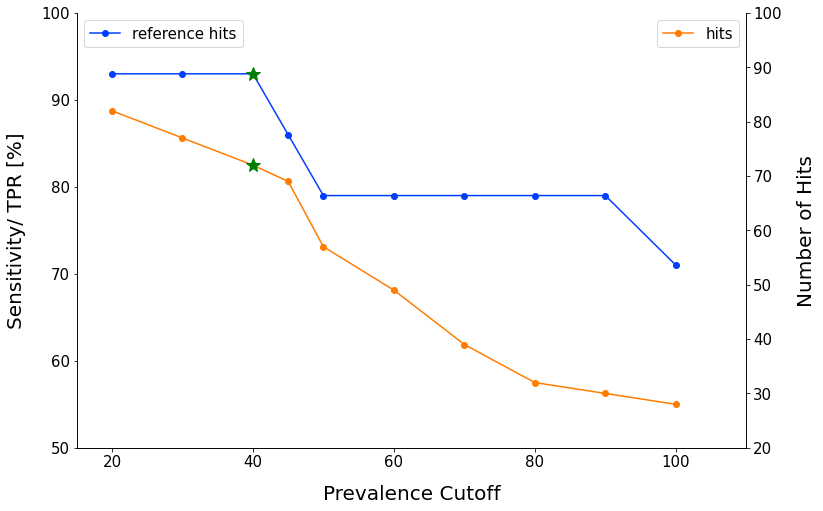

In [31]:
#insert captured reference CMs and overall hits for given cut-offs for combines prevalence
cutoffs = [20, 30, 40, 45, 50, 60, 70, 80, 90, 100]

save_ref = [0.93, 0.93, 0.93, 0.86, 0.79, 0.79, 0.79, 0.79, 0.79, 0.71]
refs = [element * 100 for element in save_ref]

save_new_hits = [82, 77, 72, 69, 57, 49, 39, 32, 30, 28]

#plot graphs
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 8)

ax1.spines["top"].set_visible(False)
ax1.tick_params(labelsize = 15)

ax1.set_xlim(15, 110)
ax1.set_ylim(50, 100)

ax1.set_xlabel('Prevalence Cutoff', size = 20, labelpad = 15)
ax1.set_ylabel('Sensitivity/ TPR [%]', size = 20, labelpad = 15)

ax1.plot(cutoffs, refs, color = colors[0], marker = 'o', label = 'reference hits')
plt.plot(cutoffs[2], refs[2], 'g*', markersize = 15)
ax1.tick_params(axis = 'y')
ax1.legend(loc = 2, fontsize = 15)

ax2 = ax1.twinx()
ax2.spines["top"].set_visible(False)
ax2.tick_params(labelsize = 15)

ax2.set_ylim(20, 100)

ax2.set_ylabel('Number of Hits', size = 20, labelpad = 15)  

ax2.plot(cutoffs, save_new_hits, color = colors[1], marker = 'o', label = 'hits')
plt.plot(cutoffs[2], save_new_hits[2], 'g*', markersize = 15)
ax2.tick_params(axis = 'y')
ax2.legend(loc = 0, fontsize = 15)

**Table S2: Hit list of Fisher’s exact test for association of resistance with co-occuring mutations af- ter applying a filter for combined prevalence of resistance and CM.**

In [33]:
hits = pandas.read_excel('hits.xlsx')
rows = []

for res in hits.resistant_mutation.unique():
    res_samples = MUTATIONS[MUTATIONS.GENE_MUTATION==res].UNIQUEID
    
    for other in hits.other_mutation.unique():
        prevalence = len(MUTATIONS[(MUTATIONS.GENE_MUTATION==other) 
                                   & (MUTATIONS.UNIQUEID.isin(res_samples))].UNIQUEID)
        
        if prevalence > 40:     
            rows.append([res, other, prevalence])
            
hits_filtered = pandas.DataFrame(rows, columns = ['resistance mutation', 'putative CM', 'prevalence'])
print(hits_filtered.to_latex(index = False))

\begin{tabular}{llr}
\toprule
resistance mutation &    putative CM &  prevalence \\
\midrule
         rpoB\_S450L &     rpoC\_N826T &          64 \\
         rpoB\_S450L &     rpoC\_D485Y &         194 \\
         rpoB\_S450L &     rpoB\_A692T &          79 \\
         rpoB\_S450L &     rpoB\_I480V &          78 \\
         rpoB\_S450L &     rpoC\_H525Q &          46 \\
         rpoB\_S450L &     rpoA\_V183G &          77 \\
         rpoB\_S450L &    rpoC\_E1092D &        1989 \\
         rpoB\_S450L &     rpoB\_A286V &          56 \\
         rpoB\_S450L &     rpoB\_V496A &          60 \\
         rpoB\_S450L &     rpoC\_T812I &          51 \\
         rpoB\_S450L &     rpoC\_G519D &          51 \\
         rpoB\_S450L &     rpoB\_c-61t &         737 \\
         rpoB\_S450L &     rpoC\_W484G &          80 \\
         rpoB\_S450L &    rpoC\_P1040S &         118 \\
         rpoB\_S450L &     rpoB\_Q975H &          65 \\
         rpoB\_S450L &     rpoC\_P481T &          69 \\
         rp

**Figure 4: Growth and lineage distributions of M. tuberculosis samples that are pan-susceptible, rifampicin (RIF) resistant and resistant with compensatory mutations (CMs)**

**4(A)** Distribution of growth in percent as measured in the CRyPTIC project, plotted against the proportion of samples that display this amount of growth. This plot represents the overall data set.

resistant to susceptible: 7.66387726655333e-17 p-value to res 3.75380263616983e-54 p-value to sus 6.2431774864011485e-22
ConfidenceInterval(low=16.47378045627297, high=17.813421707460982)
ConfidenceInterval(low=17.84277397600092, high=18.716718120739664)
ConfidenceInterval(low=19.725914392869967, high=20.823283898374907)


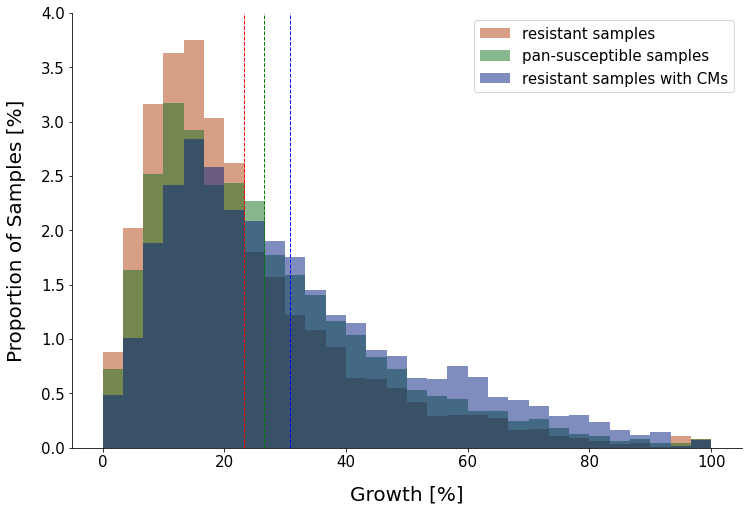

In [68]:
#set color palette
colors = sns.color_palette("dark")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#load UNIQUEIDs of resistant samples with CMs
res_CM_samples = []

for i, name in enumerate(hits.resistant_mutation.unique()):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == name)].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))].UNIQUEID.unique()
    
    res_CM_samples.append(hit_samples_local)

res_CM_samples = numpy.concatenate(res_CM_samples)
res_CM_samples = pandas.Series(res_CM_samples)

#load UNIQUEIDs of resistant samples without CMs
res_samples = EFFECTS[~(EFFECTS.UNIQUEID.isin(res_CM_samples))].UNIQUEID.values.tolist()
res_samples = pandas.Series(res_samples)

#load growth data for susceptible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(res_samples.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#load growth data for resistant with CMs UNIQUEIDs
resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.values.tolist()))].IM_POS_AVERAGE
resistant_CM.dropna(inplace = True)

#calculate p-values
stat1, p1 = mannwhitneyu(resistant, susceptible)
stat2, p2 = mannwhitneyu(resistant, resistant_CM)
stat3, p3 = mannwhitneyu(resistant_CM, susceptible)

#save p-value and median
p_values_medians = []
p_values_medians.append(['susceptible (sus)', round(numpy.mean(susceptible), 2), '', '', len(susceptible)])
p_values_medians.append(['resistant and no CMs (res)', round(numpy.mean(resistant), 2), '', '', len(resistant)])
p_values_medians.append(['resistant and any CMs', round(numpy.mean(resistant_CM), 2), str(p2), str(p3), 
                         len(resistant_CM)])

print('resistant to susceptible:',p1, 'p-value to res', p2, 'p-value to sus', p3)

#calculate and print confidence intervals
for state in (resistant, susceptible, resistant_CM):
    state = (state,)
    CI = bootstrap(state, numpy.std, confidence_level = 0.95, n_resamples = 1000)
    print(CI.confidence_interval)

#plot growth distributions
fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(12, 8)

plt.hist(resistant, bins = 30, alpha = 0.5, label = "resistant samples", density=True, color = colors[1])
plt.axvline(numpy.mean(resistant), color = 'r', linestyle = 'dashed', linewidth=1)

plt.hist(susceptible, bins = 30, alpha = 0.5, label = "pan-susceptible samples", density = True, color = colors[2])
plt.axvline(numpy.mean(susceptible), color = 'g', linestyle = 'dashed', linewidth = 1)

plt.hist(resistant_CM, bins = 30, alpha = 0.5, label = "resistant samples with CMs", density = True, color = colors[0])
plt.axvline(numpy.mean(resistant_CM), color = 'b', linestyle = 'dashed', linewidth = 1)

plt.xlabel("Growth [%]", size = 20, labelpad = 15)
plt.ylabel("Proportion of Samples [%]", size = 20, labelpad = 15)

plt.xticks(fontsize = 15)

y = [0.000, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
values = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
plt.yticks(y, values, fontsize = 15)

plt.legend(loc = 'upper right', fontsize = 15)

**4(B)** (left) Lineage distribution for all samples

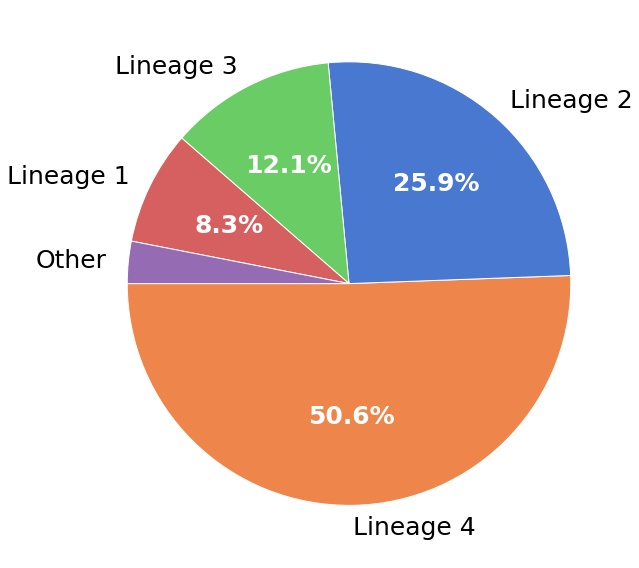

In [35]:
#set color palette
colors = sns.color_palette("muted")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#concatenate all lineages with low prevalence (all except 1-4)
query = ['Mixed', 'Unknown', 'Lineage Bovis', 'Lineage 5', 'Lineage 6', 'Lineage 7', 'Lineage Caprae']
query

GENOMES['cut_lineages'] = GENOMES.MYKROBE_LINEAGE_NAME_1
GENOMES.cut_lineages.loc[GENOMES.MYKROBE_LINEAGE_NAME_1.isin(query)] = 'Other'
GENOMES[(GENOMES.cut_lineages == 'Other')]

lineages = GENOMES.cut_lineages.value_counts()

#plot lineage distribution
fig, axes = plt.subplots()
fig.set_size_inches(12, 8)

def my_autopct(pct):
    return ('%.1f%%'% pct) if pct > 5 else ''

patches, texts, pcts = plt.pie(lineages, labels = lineages.index, autopct = my_autopct, startangle = 180, 
                               wedgeprops = {'linewidth': 1.0, 'edgecolor': 'white'}, 
                               textprops = {"fontsize":25})

for j, patch in enumerate(patches):
            if texts[j].get_text() == 'Lineage 2':
                patch.set_facecolor(colors[0])
            if texts[j].get_text() == 'Lineage 4':
                patch.set_facecolor(colors[1])
            if texts[j].get_text() == 'Lineage 3':
                patch.set_facecolor(colors[2])
            if texts[j].get_text() == 'Lineage 1':
                patch.set_facecolor(colors[3])
            if texts[j].get_text() == 'Other':
                patch.set_facecolor(colors[4])

plt.setp(pcts, color = 'white', fontweight = 'bold')
plt.tight_layout()

**4(B)** (right) Lineage distribution for samples with the most prevalent resistance mutation S450L

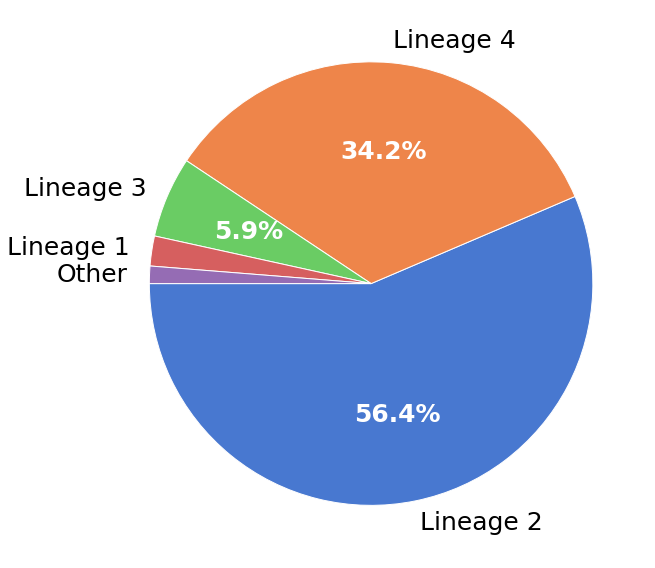

In [36]:
#set color palette
colors = sns.color_palette("muted")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#retrieve lineages of all samples with resistance mutation S450L
resistant_mutation_samples = MUTATIONS[(MUTATIONS.GENE_MUTATION == 'rpoB_S450L')].UNIQUEID
lineages = GENOMES[(GENOMES.index.isin(resistant_mutation_samples))].cut_lineages.value_counts()

#plot lineage distribution
fig, axes = plt.subplots()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(12, 8)

def my_autopct(pct):
    return ('%.1f%%'% pct) if pct > 5 else ''

patches, texts, pcts = plt.pie(lineages, labels = lineages.index, startangle = 180, autopct = my_autopct,
                               wedgeprops = {'linewidth': 1.0, 'edgecolor': 'white'}, 
                               textprops = {"fontsize":25})

for j, patch in enumerate(patches):
    if texts[j].get_text() == 'Lineage 2':
        patch.set_facecolor(colors[0])
    if texts[j].get_text() == 'Lineage 4':
        patch.set_facecolor(colors[1])
    if texts[j].get_text() == 'Lineage 3':
        patch.set_facecolor(colors[2])
    if texts[j].get_text() == 'Lineage 1':
        patch.set_facecolor(colors[3])
    if texts[j].get_text() == 'Other':
        patch.set_facecolor(colors[4])
    

plt.setp(pcts, color = 'white', fontweight = 'bold')
plt.tight_layout()

**Figure 3D,E,F,G and S2: Plot growth distribution of all pan-susceptible samples against those with a specific resistance mutations and those with this resistance mutations and a specific CM incl. p-value calculation**

rpoB_S450L_rpoC_E1092D resistant to susceptible: 3.650214223947624e-06 resistant to resistant + CMs 3.139867119343947e-13 susceptible to resistant + CMs 2.7820591307339676e-09
ConfidenceInterval(low=17.332854996392886, high=19.38240166959321)
ConfidenceInterval(low=17.89514357925941, high=18.704170856225613)
ConfidenceInterval(low=15.849040211021393, high=20.948056266916193)
rpoB_S450L_rpoC_V483G resistant to susceptible: 3.650214223947624e-06 resistant to resistant + CMs 0.0063753771139158635 susceptible to resistant + CMs 0.4582132462024644
ConfidenceInterval(low=17.298237798501162, high=19.427779677213714)
ConfidenceInterval(low=17.784863564417876, high=18.694974210761856)
ConfidenceInterval(low=16.831089020789065, high=21.249368583077388)
rpoB_S450L_rpoB_c-61t resistant to susceptible: 3.650214223947624e-06 resistant to resistant + CMs 1.8897560210517747e-08 susceptible to resistant + CMs 0.0003534008018839812
ConfidenceInterval(low=17.25138132368897, high=19.329554812346764)
Confi

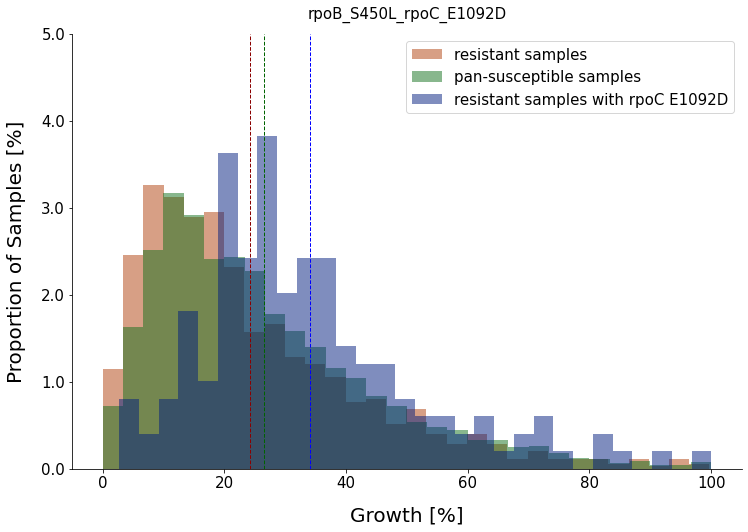

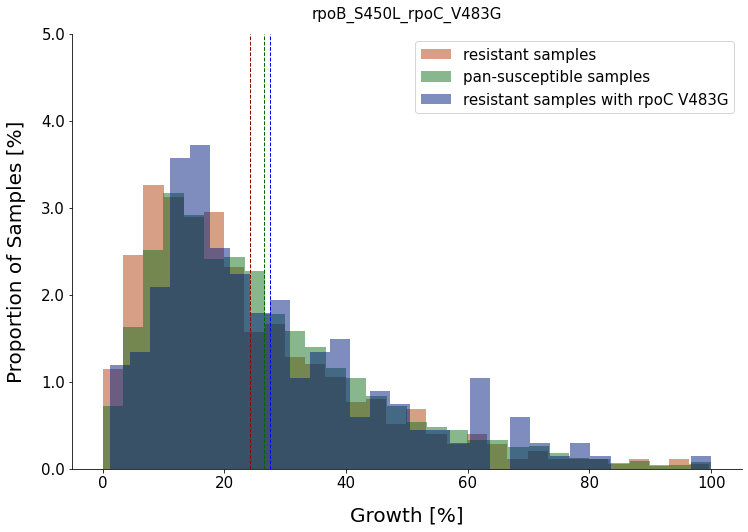

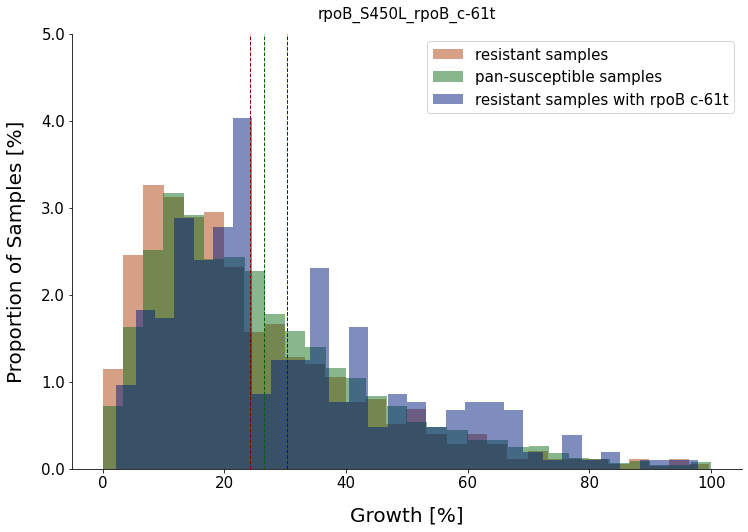

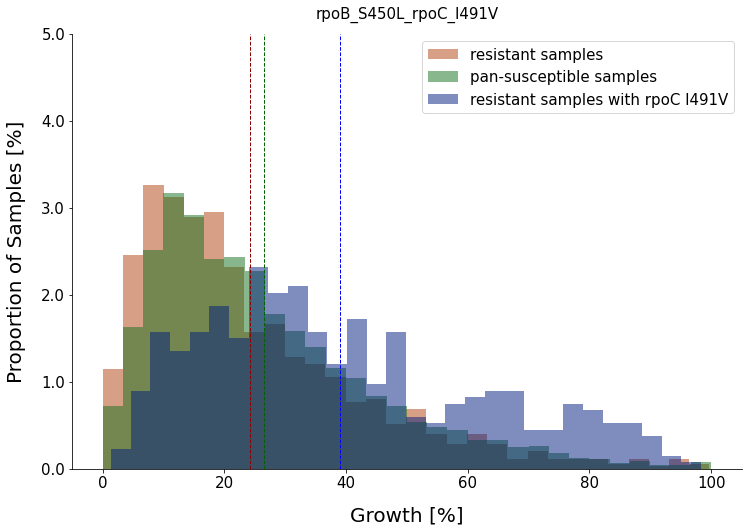

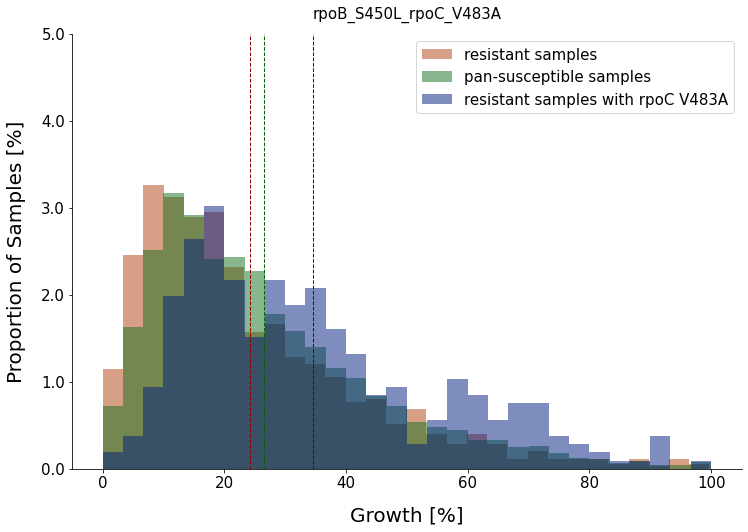

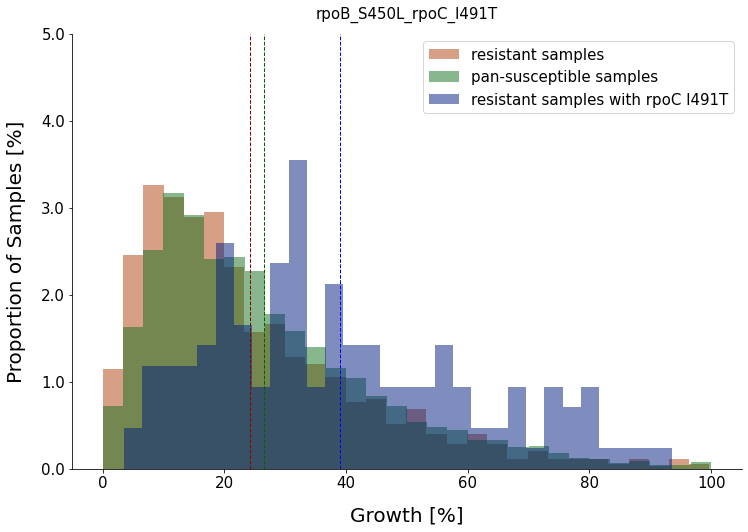

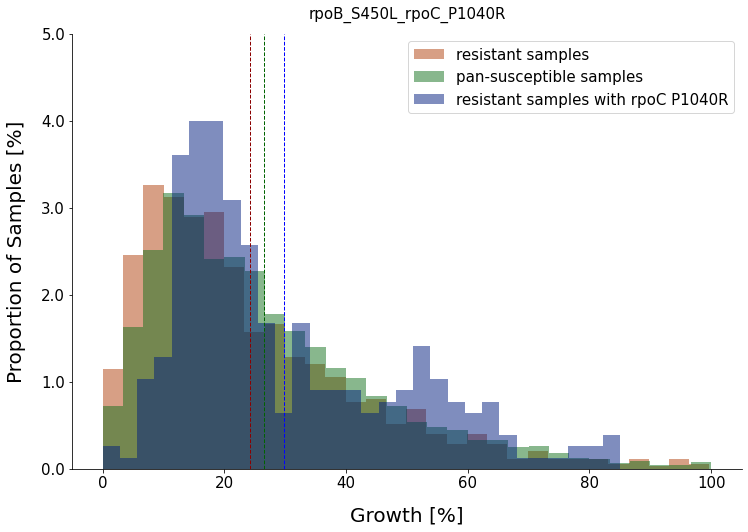

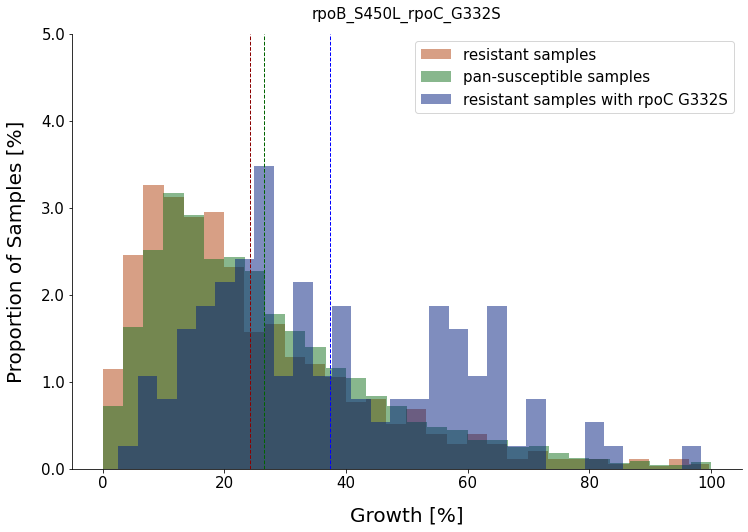

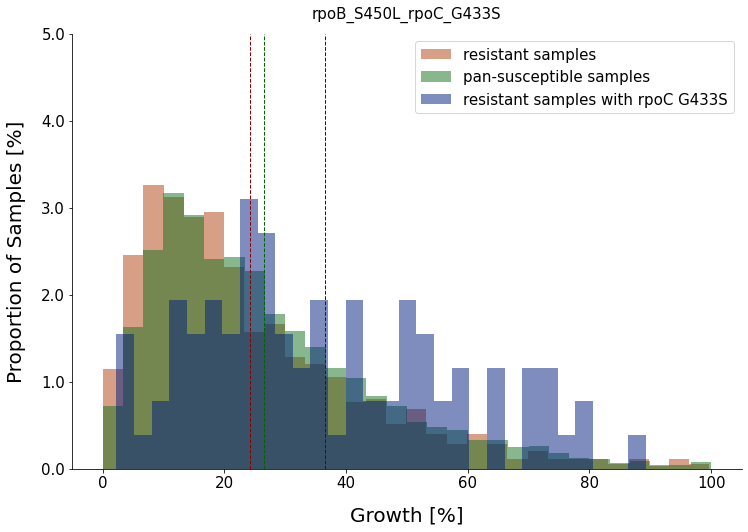

In [69]:
#set color palette
colors = sns.color_palette("dark")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#make list of samples with resistance mutations and CMs
concat_samples = []

for i, name in enumerate(hits.resistant_mutation.unique()):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == hits.resistant_mutation.unique()[i])].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))].UNIQUEID.unique()
    
    concat_samples.append(hit_samples_local)

concat_samples = numpy.concatenate(concat_samples)
concat_samples = pandas.DataFrame(concat_samples,columns=['UNIQUEID'])

#make list of observed combinations of resistance and CM
hit_samples = []
name = []

for i, mut in enumerate(hits.resistant_mutation.unique()):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == hits.resistant_mutation.unique()[i])].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))]
    name_local = mut + '_' + hit_samples_local.GENE_MUTATION
    
    name.append(name_local)
    hit_samples.append(hit_samples_local.UNIQUEID)

hit_samples = numpy.concatenate(hit_samples)
name = numpy.concatenate(name)
hit_samples = pandas.DataFrame(hit_samples,name,columns = ['UNIQUEID'])

#filter out all combinations with prevalence of <100
hit_samples = hit_samples.reset_index()
hit_samples.rename(columns = {'index':'mutations'}, inplace = True) 

prevalence = hit_samples.mutations.value_counts()>100
combinations = prevalence[prevalence].index.tolist()

hit_samples = hit_samples.set_index('mutations')

susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

for i, combination in enumerate(combinations):
    res_CM_samples = hit_samples.loc[combination]
    
    #only include resistant samples with specific resistance mutation in combination
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist())) 
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist())))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #set reasonable prevalence cutoff
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-values
    stat, p1 = mannwhitneyu(resistant, susceptible)
    stat, p2 = mannwhitneyu(resistant, resistant_CM)
    stat, p3 = mannwhitneyu(resistant_CM, susceptible)
    
    print(combination, 'resistant to susceptible:',p1, 'resistant to resistant + CMs', p2, 'susceptible to resistant + CMs', p3)
    
    #calculate and print confidence intervals
    for state in (resistant, susceptible, resistant_CM):
        state = (state,)
        CI = bootstrap(state, numpy.std, confidence_level = 0.95, n_resamples = 1000)
        print(CI.confidence_interval)
    
    #plot growth distributions below p-value cut-off
    if p2 < (0.01): 
        fig, ax = plt.subplots()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        fig.set_size_inches(12, 8)

        plt.hist(resistant, bins = 30, alpha = 0.5, label="resistant samples", density = True, color = colors[1])
        plt.axvline(numpy.mean(resistant), color = 'darkred', linestyle = 'dashed', linewidth = 1)
        
        plt.hist(susceptible, bins = 30, alpha = 0.5, label = "pan-susceptible samples", 
                 density = True, color = colors[2])
        plt.axvline(numpy.mean(susceptible), color = 'darkgreen', linestyle = 'dashed', linewidth = 1)
        
        plt.hist(resistant_CM, bins = 30, alpha = 0.5, 
                 label = "resistant samples with " + combination[11:15] + ' ' + combination[16:], 
                 density = True, color = colors[0])
        plt.axvline(numpy.mean(resistant_CM), color = 'b', linestyle = 'dashed', linewidth = 1)

        plt.xlabel("Growth [%]", size = 20, labelpad = 15)
        plt.ylabel("Proportion of Samples [%]", size = 20, labelpad = 15)
        
        plt.xticks(fontsize = 15)
        
        y = [0.000, 0.01, 0.02, 0.03, 0.04, 0.05]
        values = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
        plt.yticks(y, values, fontsize = 15)

        plt.legend(loc = 'upper right', fontsize = 15)
        plt.title(combination, fontsize = 15, pad = 15)
        
        #save p-values and medians
        p_values_medians.append([combination[11:], round(numpy.mean(resistant_CM), 2), 
                                 str(p2), str(p3), len(resistant_CM)])
        

**Supplementary Table S3: Median growth and Mann-Whitney p-values of samples with different compensatory mutations compared to susceptibles and samples with only resistance**

In [41]:
table = pandas.DataFrame(p_values_medians, 
                         columns = ['mutation','mean growth [%]', 'p-value to res', 'p-value to sus', 'n'], 
                         index = None)

print(table.to_latex(index = False))

\begin{tabular}{lrllr}
\toprule
                  mutation &  mean growth [\%] &         p-value to res &         p-value to sus &    n \\
\midrule
         susceptible (sus) &            26.48 &                        &                        & 5283 \\
resistant and no CMs (res) &            23.18 &                        &                        & 2554 \\
     resistant and any CMs &            30.87 &   3.75380263616983e-54 & 6.2431774864011485e-22 & 2982 \\
               rpoC\_E1092D &            34.02 &  3.139867119343947e-13 & 2.7820591307339676e-09 &  153 \\
                rpoC\_V483G &            27.50 &  0.0063753771139158635 &     0.4582132462024644 &  204 \\
                rpoB\_c-61t &            30.26 & 1.8897560210517747e-08 &  0.0003534008018839812 &  327 \\
                rpoC\_I491V &            39.01 & 2.4013535372649758e-34 &   9.27128879265071e-31 &  413 \\
                rpoC\_V483A &            34.53 &  9.598935059043509e-19 &  1.801801043265379e-13 &  318 \\

**Figure 3 inlays: Distribution of TB lineages within plotted samples with CMs**

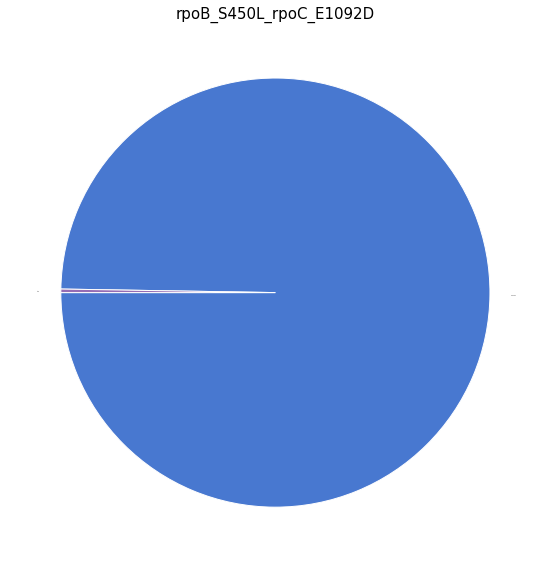

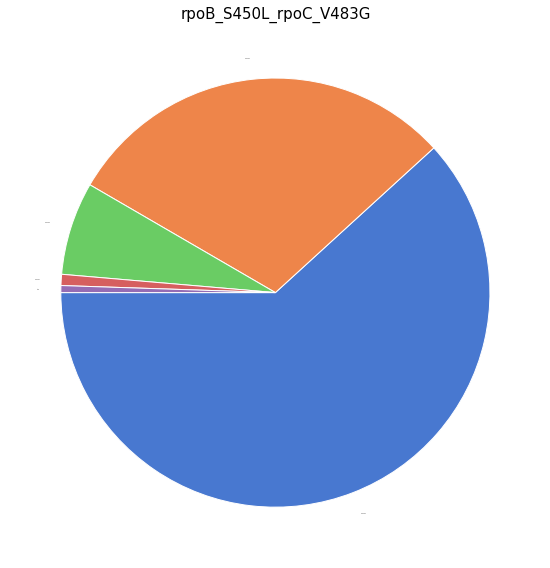

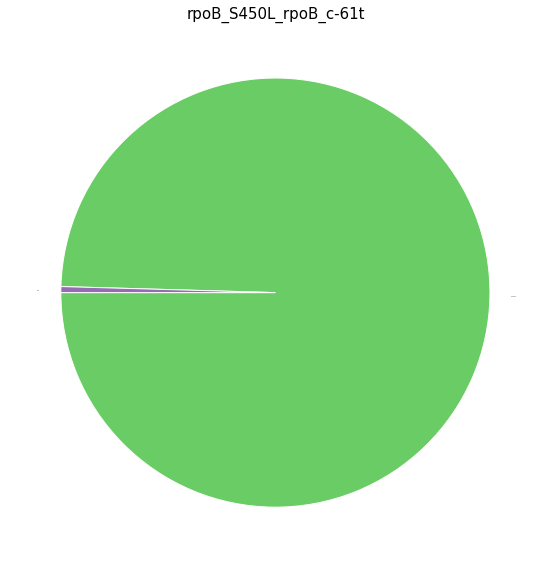

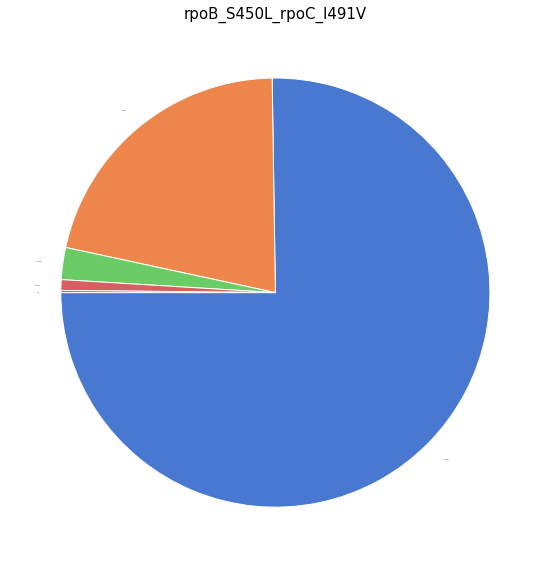

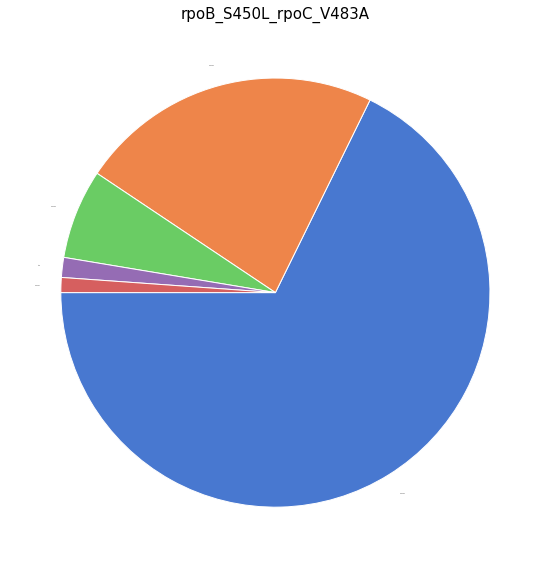

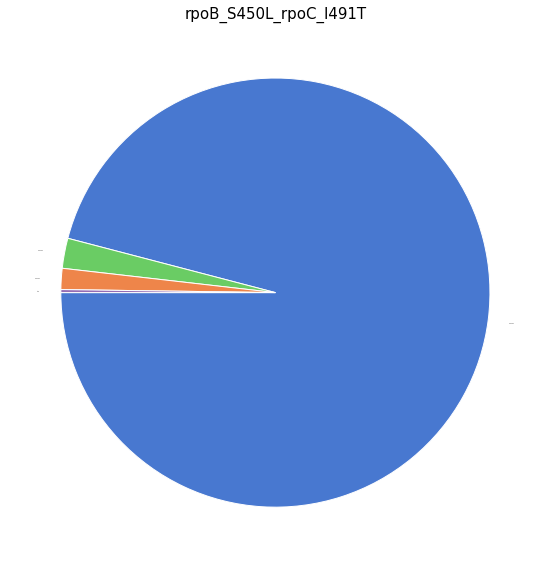

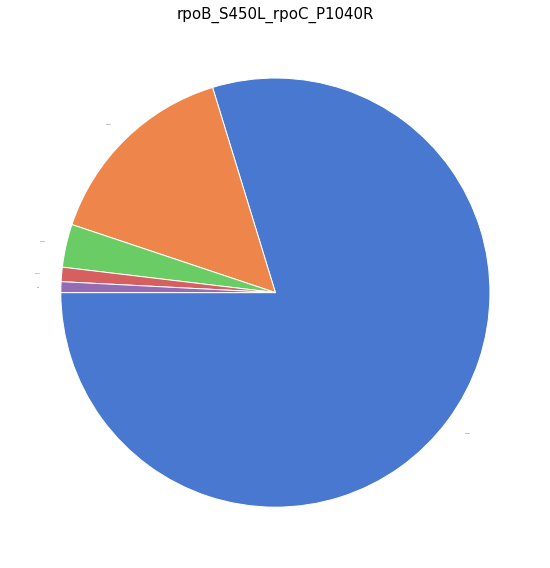

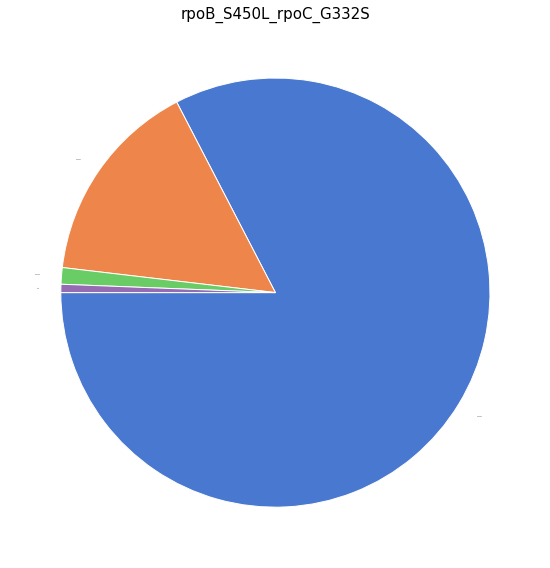

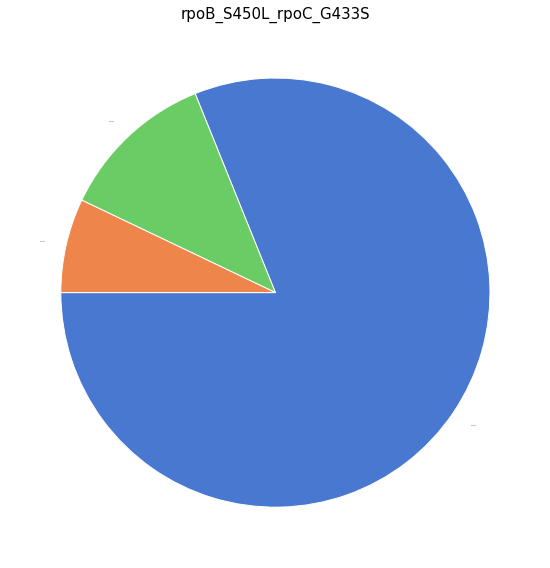

In [42]:
#set color palette
colors = sns.color_palette("muted")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

for i, combination in enumerate(combinations):
    res_CM_samples = hit_samples.loc[combination]
    lineages = GENOMES[(GENOMES.index.isin(res_CM_samples.UNIQUEID))].cut_lineages.value_counts()
    
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist()))
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist())))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #set reasonable prevalence cutoff
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-value
    stat, p2 = mannwhitneyu(resistant, resistant_CM)
    
    #plot growth distributions below p-value cut-off
    if p2 < (0.01):
        fig, axes = plt.subplots()
        fig.set_size_inches(12, 8)

        patches, texts = plt.pie(lineages, startangle = 180, labels = lineages.index,
                                       wedgeprops = {'linewidth': 1.0, 'edgecolor': 'white'}, 
                                       textprops = {"fontsize":0})

        for j, patch in enumerate(patches):
            if texts[j].get_text() == 'Lineage 2':
                patch.set_facecolor(colors[0])
            if texts[j].get_text() == 'Lineage 4':
                patch.set_facecolor(colors[1])
            if texts[j].get_text() == 'Lineage 3':
                patch.set_facecolor(colors[2])
            if texts[j].get_text() == 'Lineage 1':
                patch.set_facecolor(colors[3])
            if texts[j].get_text() == 'Other':
                patch.set_facecolor(colors[4])

            plt.title(combination, fontsize = 15)
            plt.tight_layout()
        

**Figure 4A: Analysis of Lineage 2 and 4 growth distributions**

7.988375177065574e-33


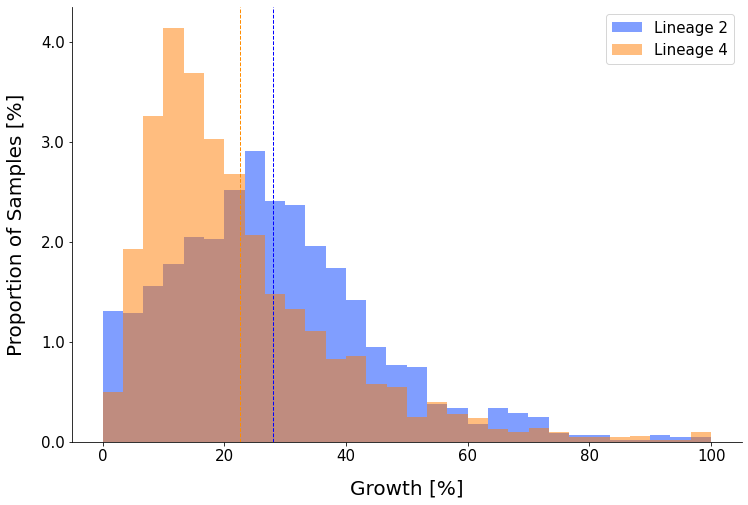

In [45]:
#set color palette
colors = sns.color_palette("bright")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

condition = GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS'])

#load growth data for lineages 2 and 4
lineage2 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 2')].index.to_series()
data2 = PLATES[(PLATES.UNIQUEID.isin(lineage2.values.tolist()))].IM_POS_AVERAGE
data2.dropna(inplace = True)

lineage4 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 4')].index.to_series()
data4 = PLATES[(PLATES.UNIQUEID.isin(lineage4.values.tolist()))].IM_POS_AVERAGE
data4.dropna(inplace = True)

#calculate p-value for growth distributions of lineages 2 and 4
stat5, p5 = mannwhitneyu(data2, data4)

print(p5)

#plot lineage growth distributions
fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(12, 8)

plt.hist(data2, bins = 30, alpha = 0.5, label = "Lineage 2", density = True, color = colors[0])
plt.axvline(numpy.mean(data2), color = 'b', linestyle = 'dashed', linewidth = 1)

plt.hist(data4, bins = 30, alpha = 0.5, label = "Lineage 4", density = True, color = colors[1])
plt.axvline(numpy.mean(data4), color = 'darkorange', linestyle = 'dashed', linewidth = 1)

plt.xlabel("Growth [%]", size = 20, labelpad = 15)
plt.ylabel("Proportion of Samples [%]", size = 20, labelpad = 15)
plt.xticks(fontsize = 15)

y = [0.00, 0.01, 0.02, 0.03, 0.04]
values = [0.0, 1.0, 2.0, 3.0, 4.0]
plt.yticks(y, values, fontsize = 15)

plt.legend(loc = 'upper right', fontsize = 15)

**Figure 4B: Analysis of all Lineage growth distributions**

0.07173783246510695 8.681782045749693e-14 1.2195220570564877e-05 8.364334313772049e-16 3.312777531300847e-64


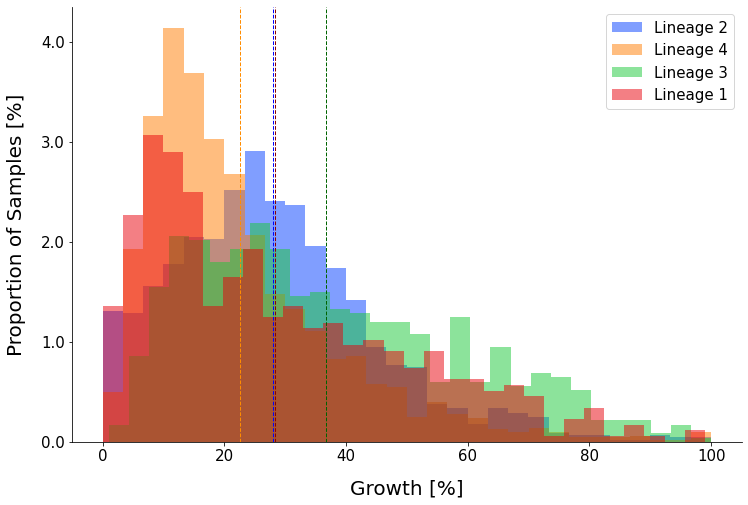

In [47]:
#set color palette
colors = sns.color_palette("bright")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#load growth data for lineages 1 and 3
lineage1 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 1')].index.to_series()
data1 = PLATES[(PLATES.UNIQUEID.isin(lineage1.values.tolist()))].IM_POS_AVERAGE
data1.dropna(inplace = True)

lineage3 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 3')].index.to_series()
data3 = PLATES[(PLATES.UNIQUEID.isin(lineage3.values.tolist()))].IM_POS_AVERAGE
data3.dropna(inplace = True)

#calculate p-values
stat1, p1 = mannwhitneyu(data1, data2)
stat2, p2 = mannwhitneyu(data1, data3)
stat3, p3 = mannwhitneyu(data1, data4)
stat4, p4 = mannwhitneyu(data2, data3)
stat6, p6 = mannwhitneyu(data3, data4)

#save p-values and medians
p_values_medians = []
p_values_medians.append([1, numpy.mean(data1), '-', str(p1), str(p2), str(p3)])
p_values_medians.append([2, numpy.mean(data2), str(p1), '-', str(p4), str(p5)])
p_values_medians.append([3, numpy.mean(data3), str(p2), str(p4), '-', str(p6)])
p_values_medians.append([4, numpy.mean(data4), str(p3), str(p5), str(p6), '-'])

print(p1, p2, p3, p4, p6)

#plot lineage growth distributions
fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(12, 8)

plt.hist(data2, bins = 30, alpha = 0.5, label = "Lineage 2", density = True, color = colors[0])
plt.axvline(numpy.mean(data2), color = 'b', linestyle = 'dashed', linewidth = 1)

plt.hist(data4, bins = 30, alpha = 0.5, label = "Lineage 4", density = True, color = colors[1])
plt.axvline(numpy.mean(data4), color = 'darkorange', linestyle = 'dashed', linewidth = 1)

plt.hist(data3, bins = 30, alpha = 0.5, label = "Lineage 3", density = True, color = colors[2])
plt.axvline(numpy.mean(data3), color = 'darkgreen', linestyle = 'dashed', linewidth = 1)

plt.hist(data1, bins = 30, alpha = 0.5, label = "Lineage 1", density = True, color = colors[3])
plt.axvline(numpy.mean(data1), color = 'darkred', linestyle = 'dashed', linewidth = 1)

plt.xlabel("Growth [%]", size = 20, labelpad = 15)
plt.ylabel("Proportion of Samples [%]", size = 20, labelpad = 15)
plt.xticks(fontsize = 15)

y = [0.00, 0.01, 0.02, 0.03, 0.04]
values = [0.0, 1.0, 2.0, 3.0, 4.0]
plt.yticks(y, values, fontsize = 15)

plt.legend(loc = 'upper right', fontsize = 15)

**Supplementary Table S4: Median growth and Mann-Whitney p-values of growth difference of Lineages 1-4**

In [48]:
table = pandas.DataFrame(p_values_medians, columns = ['Lineage', 'mean growth [%]', 'p-value to 1', 
                                                      'p-value to 2', 'p-value to 3', 'p-value to 4'], index = None)

print(table.to_latex(index = False))

\begin{tabular}{rrllll}
\toprule
 Lineage &  mean growth [\%] &           p-value to 1 &          p-value to 2 &          p-value to 3 &           p-value to 4 \\
\midrule
       1 &        28.338521 &                      - &   0.07173783246510695 & 8.681782045749693e-14 & 1.2195220570564877e-05 \\
       2 &        28.067137 &    0.07173783246510695 &                     - & 8.364334313772049e-16 &  7.988375177065574e-33 \\
       3 &        36.659320 &  8.681782045749693e-14 & 8.364334313772049e-16 &                     - &  3.312777531300847e-64 \\
       4 &        22.552677 & 1.2195220570564877e-05 & 7.988375177065574e-33 & 3.312777531300847e-64 &                      - \\
\bottomrule
\end{tabular}



**Figure 4C-F/ S3: Plot only susceptibles within lineage 2 against resistance + CM in lineage 2 for all remaining CMs to find out if better growth than wildtype is only due to lineage 2 prevalence in resistant samples**

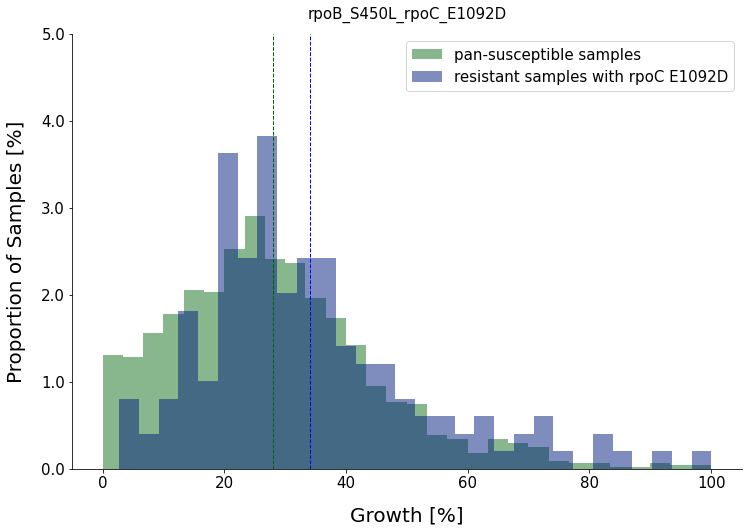

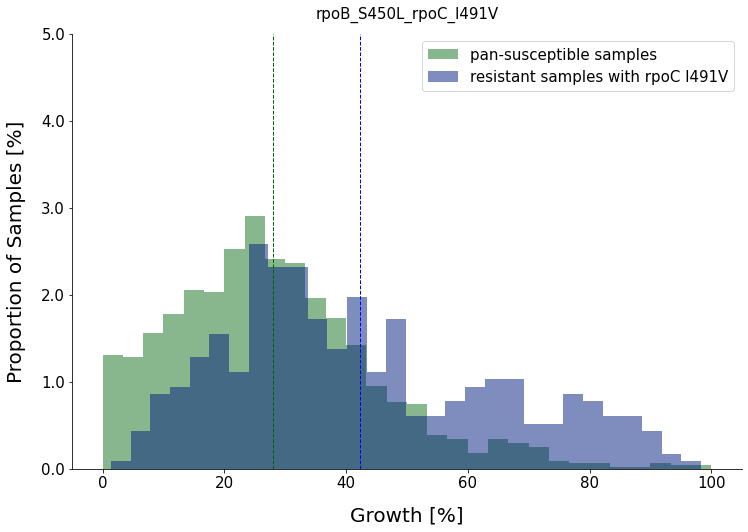

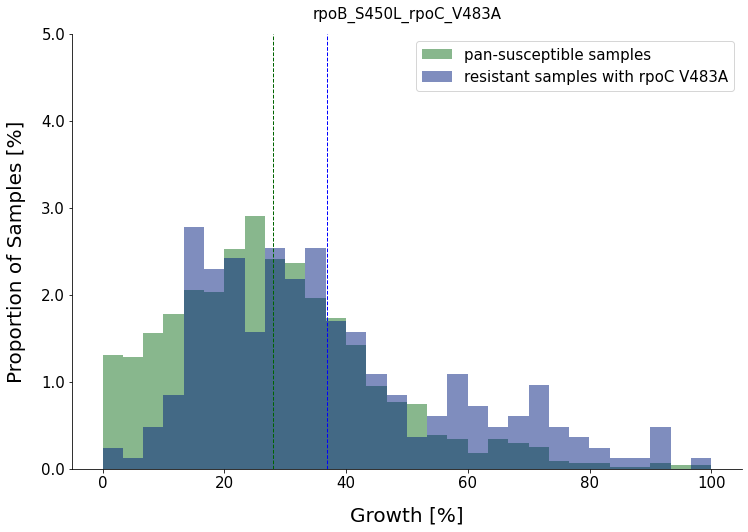

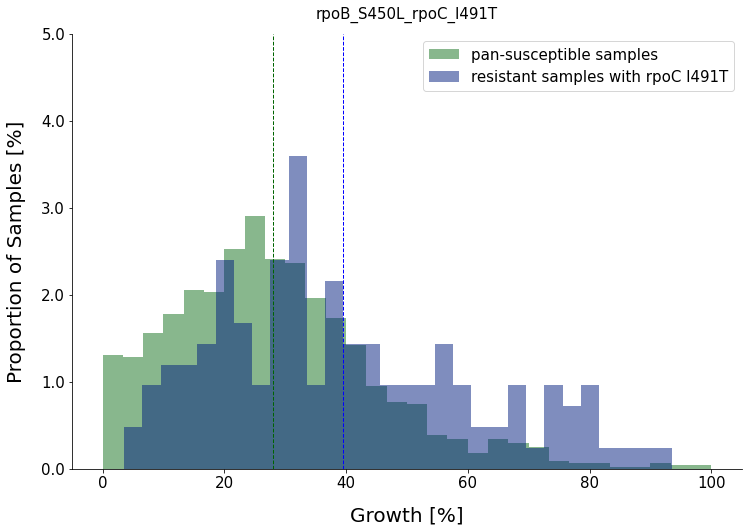

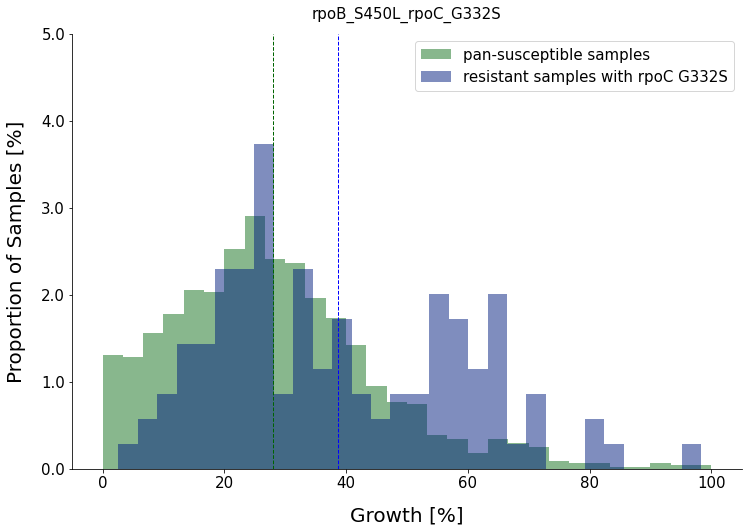

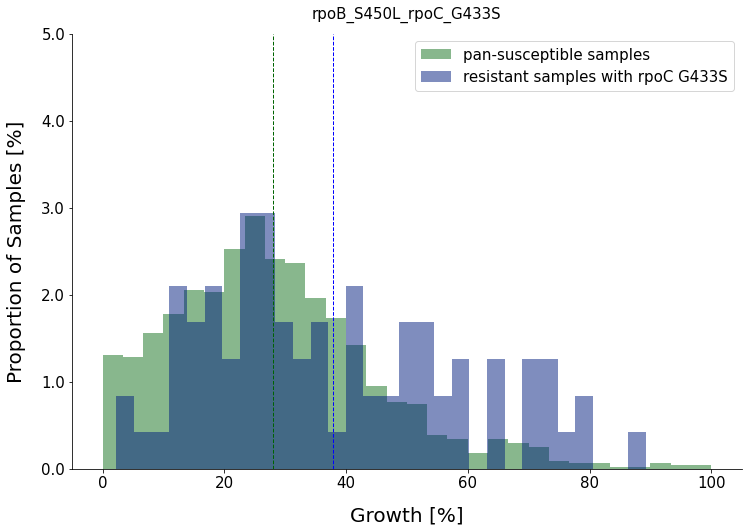

In [52]:
#set color palette
colors = sns.color_palette("dark")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#load growth data for susceptibles in lineage 2
condition1 = GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS'])
condition2 = GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 2'

lineage2 = GENOMES[(condition1) & (condition2)].index.to_series()
susceptible = PLATES[(PLATES.UNIQUEID.isin(lineage2.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#save p-values and medians
p_values_medians = []
p_values_medians.append(['susceptible (sus)', numpy.mean(susceptible), ' ', ' ', len(susceptible)])

for i, combination in enumerate(combinations):
    res_CM_samples = hit_samples.loc[combination]
    
    #load growth data for resistant+CMs samples in lineage 2
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist())) 
                          & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                          == 'Lineage 2'].index.to_series()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #load growth data for resistant samples in lineage 2
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist())) 
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist()))) 
                       & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == 'Lineage 2'].index.to_series()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #save p-values and medians
    if i == 0:
        p_values_medians.append(['resistant and no CMs (res)', numpy.mean(resistant), ' ', ' ', len(resistant)])
    
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-values
    stat, p1 = mannwhitneyu(resistant_CM, susceptible)
    stat, p2 = mannwhitneyu(resistant_CM, resistant)
    
    #plot growth distributions below p-value cut-off
    if p1 < (0.01):
        
        fig, ax = plt.subplots()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        fig.set_size_inches(12, 8)

        plt.hist(susceptible, bins = 30, alpha = 0.5, label = "pan-susceptible samples", 
                 density = True, color = colors[2])
        plt.axvline(numpy.mean(susceptible), color='darkgreen', linestyle='dashed', linewidth=1)
        
        plt.hist(resistant_CM, bins = 30, alpha = 0.5, 
                 label = "resistant samples with " + combination[11:15] + ' ' + combination[16:], 
                 density = True, color = colors[0])
        plt.axvline(numpy.mean(resistant_CM), color = 'b', linestyle = 'dashed', linewidth=1)

        plt.xlabel("Growth [%]", size = 20, labelpad = 15)
        plt.ylabel("Proportion of Samples [%]", size = 20, labelpad = 15)
        
        plt.xticks(fontsize = 15)
        
        y = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05]
        values = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
        plt.yticks(y, values, fontsize = 15)

        plt.legend(loc = 'upper right', fontsize = 15)
        plt.title(combination, fontsize = 15, pad = 15)
        
        #save p-values and medians
        p_values_medians.append([combination[11:], numpy.mean(resistant_CM), str(p2), str(p1), len(resistant_CM)])
        

**Supplementary Table S5: Median growth and Mann-Whitney p-values of samples with different compensatory mutations compared to susceptibles and samples with only resistance**

In [53]:
table = pandas.DataFrame(p_values_medians, 
                         columns = ['mutation','mean growth [%]', 'p-value to res', 'p-value to sus', 'n'], 
                         index = None)

print(table.to_latex(index = False))

\begin{tabular}{lrllr}
\toprule
                  mutation &  mean growth [\%] &         p-value to res &         p-value to sus &    n \\
\midrule
         susceptible (sus) &        28.067137 &                        &                        & 1331 \\
resistant and no CMs (res) &        27.330119 &                        &                        &  506 \\
               rpoC\_E1092D &        34.019477 &  3.332820379933774e-06 & 0.00015215905899713654 &  153 \\
                rpoC\_I491V &        42.305278 & 2.9343551850168523e-25 &  5.247700198695069e-28 &  360 \\
                rpoC\_V483A &        36.937984 & 3.1820852569860234e-11 & 1.3204686201359469e-09 &  248 \\
                rpoC\_I491T &        39.426187 & 2.0281671629900353e-10 & 1.4401800101294675e-09 &  139 \\
                rpoC\_G332S &        38.648257 &  1.549107008001238e-08 & 2.0830536712299127e-07 &  109 \\
                rpoC\_G433S &        37.835122 &  5.766429498114876e-06 & 5.3616400299751655e-05 &   82 \

**Table 2: Final list with all significantly resistance-associated putative CMs without the presumed lineage associated ones**

Excluded all mutations with over 95% of samples originating from one lineage only from downstream analysis, since they are most likely not directly resistance associated except for if they came up as clearly enhancing growth within lineage 2:
- final hit list is saved as 'hits_filtered_lineages.xlsx' and has additional columns for likely resistance association and most common lineage for samples with this mutation

In [55]:
hits_filter = pandas.read_excel('hits_filtered_lineages.xlsx')
hits_filter = hits_filter[hits_filter.directly_resistance_associated==True]
hits_final = hits[hits.other_mutation.isin(hits_filter.other_mutation)]

reference = pandas.read_excel(r'/Users/vbrunner/packages/tb-rnap-compensation/Ref_CMs.xlsx', 
                              sheet_name = 'described_CMs_binary')
reference.drop([0,1,2,3], axis = 0, inplace = True)
reference.drop(index = reference.index[-2:], axis = 0, inplace = True)

print('new CMs:', len(hits_final[~hits_final.other_mutation.isin(reference['mutation'])].other_mutation.unique()))
print('total CMs:', len(hits_final.other_mutation.unique()))

hits_final['literature evidence'] = hits_final.other_mutation.isin(reference['mutation'])
hits_final['literature evidence'] = ['\u2713' if x == True else '\u2717' for x in hits_final['literature evidence']]

growth_confirmation = ['rpoC_E1092D', 'rpoC_I491V', 'rpoC_I491T', 'rpoC_V483A', 'rpoC_V483G', 'rpoC_G332S', 'rpoC_G433S', 'rpoC_P1040R']
growth_resistance = ['rpoB_S450L']

hits_final['exp. evidence'] = hits_final.other_mutation.isin(growth_confirmation) & hits_final.resistant_mutation.isin(growth_resistance)
hits_final['exp. evidence'] = ['\u2713' if x == True else '\u2717' for x in hits_final['exp. evidence']]

hits_final = hits_final.rename(columns = {'resistant_mutation': 'resistance CM', 'other_mutation': 'putative CM'})

print(hits_final.to_latex(index = False))

new CMs: 13
total CMs: 50
\begin{tabular}{llll}
\toprule
resistance CM &    putative CM & literature evidence & exp. evidence \\
\midrule
   rpoB\_S450L &     rpoC\_D485Y &                   ✓ &             ✗ \\
   rpoB\_S450L &     rpoB\_I480V &                   ✓ &             ✗ \\
   rpoB\_S450L &     rpoC\_H525Q &                   ✓ &             ✗ \\
   rpoB\_S450L &     rpoA\_V183G &                   ✓ &             ✗ \\
   rpoB\_S450L &    rpoC\_E1092D &                   ✗ &             ✓ \\
   rpoB\_L430P &    rpoC\_E1092D &                   ✗ &             ✗ \\
   rpoB\_V170F &    rpoC\_E1092D &                   ✗ &             ✗ \\
   rpoB\_S450L &     rpoB\_A286V &                   ✓ &             ✗ \\
   rpoB\_S450L &     rpoB\_V496A &                   ✗ &             ✗ \\
   rpoB\_S450L &     rpoC\_T812I &                   ✓ &             ✗ \\
   rpoB\_S450L &     rpoC\_G519D &                   ✓ &             ✗ \\
   rpoB\_S450W &     rpoC\_G519D &              

**Figure 5: Location of putative CMs on RNAP structure**

Done outside of this notebook, simply mapped the list of prevalence-filtered, directly resistance-associated hits onto a PyMOL structure of the TB RNA polymerase with bound Rifampicin. The crystal structure for the PyMOL file was obtained by Lin et al (pdb: 5UHB).